In [193]:
import torch
import os
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image


In [194]:
class ResBlock(nn.Module):
    def __init__(self,in_channel,filter_size):
        super().__init__()
        self.in_channel = in_channel
        self.filter_size = filter_size
        
        self.conv1 = nn.Conv2d(self.in_channel, self.filter_size,
                              kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(self.filter_size, self.filter_size,
                              kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(self.in_channel, self.filter_size, kernel_size =1)
        self.bn1 = nn.BatchNorm2d(filter_size)
        self.bn2 = nn.BatchNorm2d(filter_size)
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self,x):
        identity = self.conv3(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        
        return out

In [195]:
class ResNet(nn.Module):
    def __init__(self, in_channel, out_channel, block, layers):
        super(ResNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channel, layers[0], kernel_size = 3, padding = 1)
        self.layer1 = block(layers[0],layers[1])
        self.layer2 = block(layers[1],layers[2])
        self.conv2 = nn.Conv2d(layers[2],out_channel,kernel_size=3, padding =1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.conv2(x)
        x = self.tanh(x)
        
        return x

In [196]:
import re

def find_label(name, img_list):
    for img in img_list:
        x = re.search("^\w+[_]",name) 
        y = re.search("^\w+[_]", img)
        if x.group() == y.group() :
            return img
    return None

In [240]:
len(x_data)

192

In [198]:
class myDataset(Dataset):
    def __init__(self,diff_dir, nor_dir, transform=None):
        self.colorDir = diff_dir
        self.norDir = nor_dir
        self.transform =transform
    def __len__(self):
        return len(os.listdir(self.colorDir))
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x_data = os.listdir(self.colorDir)
        y_data = os.listdir(self.norDir)
        color = Image.open(self.colorDir+"/"+x_data[idx])
        normal = Image.open(self.norDir+"/"+find_label(x_data[idx],y_data))
        if self.transform:
            color = self.transform(color)
            normal = data_transform(normal)
        return color,normal

In [199]:
#Load Images
DIFF_DIREC = os.getcwd()+"/crop_image/diff"
NOR_DIREC = os.getcwd()+"/crop_image/nor"
DISP_DIREC = os.getcwd()+"/crop_image/disp"
x_data = os.listdir(DIFF_DIREC)
y_data = os.listdir(NOR_DIREC)

In [256]:
data_transform = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [257]:
dataset = myDataset(diff_dir = DIFF_DIREC, nor_dir=NOR_DIREC, transform=data_transform)
dataloader = DataLoader(dataset, batch_size = 32,shuffle=True)

In [258]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle =True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

torch.Size([32, 3, 128, 128])


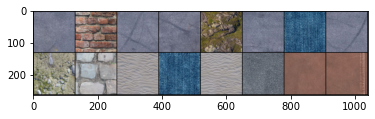

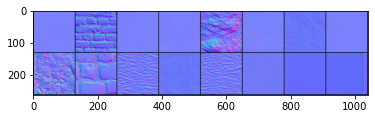

In [259]:
real_batch, real_2 = next(iter(dataloader))
print(real_batch.shape)
plt.figure()
plt.imshow(np.transpose(utils.make_grid(real_batch[:16], normalize=True).cpu(),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(utils.make_grid(real_2[:16], normalize=True).cpu(),(1,2,0)))

In [260]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(3,3,ResBlock,[32,64,128]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss().to(device)

In [ ]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    loss2 = 0
    for x,y in train_dataloader:
        x= x.to(device)
        y= y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        
        train_loss = criterion(outputs, y)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    for x,y in test_dataloader:
        x= x.to(device)
        y= y.to(device)
        outputs = model(x)
        test_loss = criterion(outputs, y)
        loss2 += test_loss.item() 
        
    loss = loss / len(train_dataloader)
    loss2 = loss2 / len(test_dataloader)
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, testloss = {:.6f}".format(epoch + 1, epochs, loss,loss2))

epoch : 1/20, loss = 1.683941, testloss = 1.366619
epoch : 2/20, loss = 1.208759, testloss = 1.081254
epoch : 3/20, loss = 1.008459, testloss = 0.955372
epoch : 4/20, loss = 0.914231, testloss = 0.901318
epoch : 5/20, loss = 0.865207, testloss = 0.857989
epoch : 6/20, loss = 0.843375, testloss = 0.847207
epoch : 7/20, loss = 0.830309, testloss = 0.829385
epoch : 8/20, loss = 0.819483, testloss = 0.832428


In [ ]:
sample_x, sample_y = next(iter(test_dataloader))
out = model(sample_x.to(device))

In [ ]:
out = out.detach().cpu()
out_img = np.transpose(utils.make_grid(out[0:4], normalize=True),(1,2,0))
plt.imshow(out_img)
plt.figure()
plt.imshow(np.transpose(utils.make_grid(sample_y[0:4], normalize=True),(1,2,0)))